<a href="https://colab.research.google.com/github/Xodarap/notebooks/blob/main/ycombinator%20valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io

df=pd.read_csv(io.StringIO(uploaded['yc_private2.csv'].decode('ISO-8859-1')))
df

Saving yc_private2.csv to yc_private2.csv


,Company,Valuation,Batch year,Valuation year,Source,implied value per year,NPV/year,Rank
0,Stripe,"$74,000,000,000.00",2009.0,2022.0,https://techcrunch.com/2022/07/20/stripes-new-...,"$5,285,714,285.71","$1,446,908,240.74",1.0
1,NASDAQ : ABNB,"$53,851,722,792.00",2009.0,NaN,NaN,NaN,NaN,NaN
2,Instacart,"$24,000,000,000.00",2012.0,2022.0,https://www.cnbc.com/2022/03/25/instacart-slas...,"$2,181,818,181.82","$836,828,256.24",2.0
3,Cruise automation,"$18,000,000,000.00",2014.0,2020.0,https://www.abiresearch.com/market-research/pr...,"$2,000,000,000.00","$1,594,323,000.00",3.0
4,OpenSea,"$13,000,000,000.00",2018.0,2022.0,https://techcrunch.com/2022/01/05/making-sense...,"$2,600,000,000.00","$2,132,325,000.00",4.0
...,...,...,...,...,...,...,...,...
322,Recurrency,NaN,2020.0,NaN,NaN,NaN,NaN,313.0
323,Karbon Card,"$60,000,000.00",2021.0,2022.0,https://app.dealroom.co/companies/karbon_card,NaN,NaN,314.0
324,NASDAQ:PRST,"$108,926,232.00",2010.0,NaN,NaN,NaN,NaN,NaN
325,NASDAQ:RGTI,"$96,219,494.00",2014.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df['Valuation year'] = df['Valuation year'].fillna(2022)
df['Valuation'] = pd.to_numeric(df['Valuation'].str.replace('[^-.0-9]', ''))
df['implied value per year'] = df['Valuation'] / (df['Valuation year'] - df['Batch year'])
df

<ipython-input-4-b98382b13754>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Valuation'] = pd.to_numeric(df['Valuation'].str.replace('[^-.0-9]', ''))


,Company,Valuation,Batch year,Valuation year,Source,implied value per year,NPV/year,Rank
0,Stripe,7.400000e+10,2009.0,2022.0,https://techcrunch.com/2022/07/20/stripes-new-...,5.692308e+09,"$1,446,908,240.74",1.0
1,NASDAQ : ABNB,5.385172e+10,2009.0,2022.0,NaN,4.142440e+09,NaN,NaN
2,Instacart,2.400000e+10,2012.0,2022.0,https://www.cnbc.com/2022/03/25/instacart-slas...,2.400000e+09,"$836,828,256.24",2.0
3,Cruise automation,1.800000e+10,2014.0,2020.0,https://www.abiresearch.com/market-research/pr...,3.000000e+09,"$1,594,323,000.00",3.0
4,OpenSea,1.300000e+10,2018.0,2022.0,https://techcrunch.com/2022/01/05/making-sense...,3.250000e+09,"$2,132,325,000.00",4.0
...,...,...,...,...,...,...,...,...
322,Recurrency,NaN,2020.0,2022.0,NaN,NaN,NaN,313.0
323,Karbon Card,6.000000e+07,2021.0,2022.0,https://app.dealroom.co/companies/karbon_card,6.000000e+07,NaN,314.0
324,NASDAQ:PRST,1.089262e+08,2010.0,2022.0,NaN,9.077186e+06,NaN,NaN
325,NASDAQ:RGTI,9.621949e+07,2014.0,2022.0,NaN,1.202744e+07,NaN,NaN


In [1]:

number_of_companies = 3951
co_per_percentile = int(number_of_companies / 100)

In [5]:
import math
sorted = [v for v in df['implied value per year'] if not math.isnan(v)]
sorted.sort(reverse = True)
adj_count = int((len(sorted) / len(df['implied value per year'])) * co_per_percentile)
percentiles = {(100-idx): sorted[adj_count * idx - 1] for idx in range(1, 9)}
percentiles[99.9] = sorted[2]

In [6]:
from scipy.optimize import curve_fit
import scipy.stats as ss
from scipy.stats import pareto
from scipy.stats import powerlaw
from scipy.optimize import minimize
import numpy as np
fitted = []
failed = []
dist_list = [['pareto', [.8, 10000, 1000000]],
             ['lognorm', [10, 10, 10]],
             ['powerlaw', [0.01, 10000000, 100000000000]],
             ['norm', [1000, 1e9]]]
data_out = [float(k)/100 for k in percentiles.keys()]
data_in = [v for v in percentiles.values()]

for d in dist_list:

    dist_name = d[0] #fetch the distribution name
    dist_object = getattr(ss, dist_name)  #fetch the distribution object
    param_default = d[1] #fetch the default distribution parameters

    # For distributions with only location and scale set those to the default loc=0 and scale=1
    if not param_default:
        param_default = (0,1)
    
    # Computed parameters of fitted distribution
    try:
        param,cov = curve_fit(dist_object.cdf,data_in,data_out,p0=param_default,method='trf')

        # Only take distributions which do not result in zero covariance as those are not a valid fit
        if np.any(cov):
            fitted.append((dist_name,param),)

    # Capture which distributions are not possible to be fitted (variety of reasons)       
    except (NotImplementedError,RuntimeError) as e:
        failed.append((dist_name,e),)
        pass

fitted
# failed

[('pareto', array([ 1.53899077e+00, -2.79288607e+08,  5.92461600e+07])),
 ('lognorm', array([ 1.84633071e+00, -1.67668888e+08,  1.45316317e+07])),
 ('powerlaw', array([ 2.21415771e-02, -7.58179471e+05,  1.32191065e+09])),
 ('norm', array([1.e+03, 1.e+09]))]

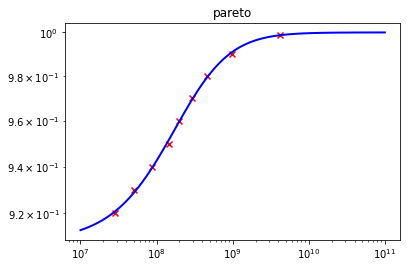

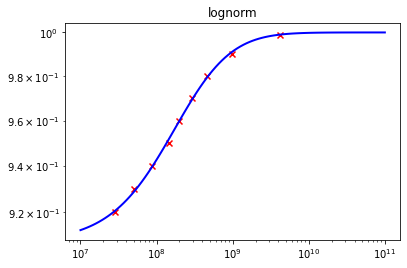

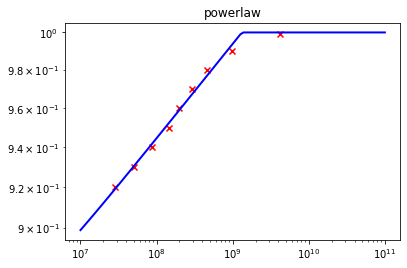

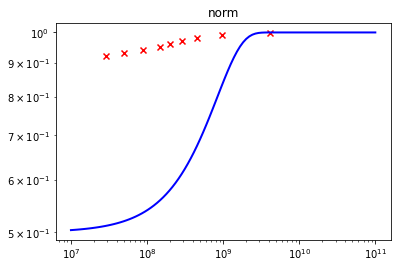

In [8]:
from matplotlib import pyplot
for f in fitted:
  pyplot.subplot(1, 1, 1)
  params = f[1]
  dist_object = getattr(ss, f[0])
  # Powers of 10
  x = np.linspace(7,11, 100)
  a = [10**i for i in x]
  # Plotting the graph
  pyplot.plot(a, dist_object.cdf(a , *params), color='blue', lw=2)
  pyplot.scatter(percentiles.values(), [float(k)/100 for k in percentiles.keys()],
                color = 'red', marker = 'x')

  # Setting a logarithmic scale for y-axis
  pyplot.yscale('log')
  pyplot.xscale('log')
  pyplot.title(f[0])
  pyplot.show()

In [9]:
for f in fitted:
  params = f[1]
  dist_object = getattr(ss, f[0])
  print(f[0], dist_object.mean(*params), params)

pareto -110121900.80290183 [ 1.53899077e+00 -2.79288607e+08  5.92461600e+07]
lognorm -87767253.207472 [ 1.84633071e+00 -1.67668888e+08  1.45316317e+07]
powerlaw 27876979.472229112 [ 2.21415771e-02 -7.58179471e+05  1.32191065e+09]
norm 1000.0 [1.e+03 1.e+09]


In [10]:
yc_companies = 3951
yc_cos_after_2019 = 1825
avg_team = 2.285714286
avg_ownership = 2/4.2

In [11]:
df['years elapsed'] = df['Valuation year'] - df['Batch year']
df['0% discount'] = df['Valuation'] / df['years elapsed']
df['12% discount'] = (.88 ** df['years elapsed']) * df['Valuation'] / df['years elapsed']
df['20% discount'] = (.8 ** df['years elapsed']) * df['Valuation'] / df['years elapsed']

In [12]:
from math import log, floor

def human_format(number):
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '$%.2f%s/y' % (number / k**magnitude, units[magnitude])

results = pd.DataFrame(
    [[k, human_format(avg_ownership * df[k].sum() / yc_companies / avg_team), 
      human_format(avg_ownership * df[k].sum() / yc_cos_after_2019 / avg_team)] 
      for k in ['0% discount', '12% discount', '20% discount']],
      columns = ['Discount', 'All companies', 'Excluding post-2019'])
results

,Discount,All companies,Excluding post-2019
0,0% discount,$4.70M/y,$10.18M/y
1,12% discount,$2.41M/y,$5.21M/y
2,20% discount,$1.60M/y,$3.47M/y


In [14]:
powerlaw_params = [f[1] for f in fitted if f[0] == 'powerlaw'][0]
powerlaw_results = pd.DataFrame(
    [[k, human_format(powerlaw.mean(*powerlaw_params) / yc_companies / avg_team), 
      human_format(df[k].sum() / yc_cos_after_2019 / avg_team)] 
      for k in ['0% discount', '12% discount', '20% discount']],
      columns = ['Discount', 'All companies', 'Excluding post-2019'])
powerlaw_results

,Discount,All companies,Excluding post-2019
0,0% discount,$3.09K/y,$21.38M/y
1,12% discount,$3.09K/y,$10.95M/y
2,20% discount,$3.09K/y,$7.30M/y
